### Analyse results sQTL

Results from the ISM can be downloaded from Zenodo.

In [1]:
import numpy as np
import pandas as pd
import h5py

import seaborn as sns
from matplotlib import pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('mode.chained_assignment', None)


### Read sQTLs

We filtered the GTEx v8 sQTL file for the hippocampus to check which genes have mutations that are within range (close enough to an exon so we can make predictions) and we only looked at the best sQTLs (lowest p-value). 

In [2]:
sQTL = pd.read_csv('../../Zenodo/Human/HPC/DL_sQTL/sQTL_hippocampus_within_best.csv', index_col=0)
sQTL_inrange = sQTL[sQTL['inrange'] == 1]

In [3]:
sQTL_inrange = sQTL_inrange.drop_duplicates()

In [4]:
### Check how many mutations we have
### We cannot make predictions for all of these though, 
### since not all are point mutations
print(len(np.unique(sQTL_inrange['Intron'])))
print(len(np.unique(sQTL_inrange['Exon'])))
print(len(sQTL_inrange))

130
169
373


### Read PSI values

Some of the sQTLs are related to exons that we removed from the data during downsampling. Therefore, here we need all the PSI values (so the NOT downsampled file).

In [5]:
PSI_glia = pd.read_csv('../../Zenodo/Human/HPC/PSI/PSI_glia_norm_ALL.csv', index_col=0)
PSI_neur = pd.read_csv('../../Zenodo/Human/HPC/PSI/PSI_neur_norm_ALL.csv', index_col=0)

PSI = pd.concat((PSI_glia, PSI_neur), axis=1)
PSI.columns = ['Glia', 'Neurons']


### Read ISM data (glia)

In [6]:
datadir = '../../Zenodo/Human/HPC/DL_sQTL'

genes = np.load(datadir+'/genes_sQTL.npz')
genes = np.array(genes['arr_0'], dtype='<U100')

ism_glia = np.load(datadir+'/ism_sQTL.npz')
ism_glia = ism_glia['arr_0']

ref_glia = np.load(datadir+'/ref_sQTL.npz')
ref_glia = ref_glia['arr_0']

sequences = np.load(datadir+'/seq_sQTL.npz')
sequences = sequences['arr_0']

spl = np.load(datadir+'/splice_sQTL.npz')
spl = spl['arr_0']

### Get predictions for the sQTLs

In [7]:
xx = sQTL_inrange['Exon'].str.split('_',expand=True)
xx.columns = ['chr', 'start', 'end', 'gene', 'strand']
xx = xx.astype({'start': int, 'end': int})

yy = sQTL_inrange['Variant'].str.split('_', expand=True).iloc[:,1:4]
yy.columns = ['snpCoor', 'snpRef', 'snpAlt']
yy = yy.astype({'snpCoor': int})
sQTL_inrange = pd.concat((sQTL_inrange, xx, yy), axis=1)

In [8]:
alphabet = 'ACGT'
ohdict = dict((c, i) for i, c in enumerate(alphabet))

res_glia = pd.DataFrame(data=np.zeros((len(sQTL_inrange),6)),
                   columns=['snpID', 'idxSNP', 'idxStart', 'idxEnd', 'refISM', 'altISM'])

for idx_sQTL in range(len(res_glia)):
    
    idx_ISM = np.where(genes == sQTL_inrange['Exon'].iloc[idx_sQTL])[0][0]
    
    start_exon = int(sQTL_inrange.iloc[idx_sQTL]['start'])
    snp = int(sQTL_inrange.iloc[idx_sQTL]['snpCoor'])
    strand = sQTL_inrange.iloc[idx_sQTL]['strand']

    if strand == '-':
        # Invert sequence + ISM scores if strand is negative
        seq = sequences[idx_ISM][::-1,::-1]
        ism = ism_glia[idx_ISM][::-1,::-1]
    else:
        seq = sequences[idx_ISM]
        ism = ism_glia[idx_ISM]

    idx_start_exon = np.where(spl[idx_ISM])[0][0] - 1 + np.sum((np.sum(seq, axis=0) == 0)[:10])
    idx_SNP = idx_start_exon + (snp-start_exon)
    
    try:
        ref = ohdict[sQTL_inrange.iloc[idx_sQTL]['snpRef']]
        alt = ohdict[sQTL_inrange.iloc[idx_sQTL]['snpAlt']]
        
        # Double check whether we're looking at the correct position
        if ref != np.argmax(seq[:,idx_SNP]):
            print('Wrong reference')

        res_glia['snpID'].iloc[idx_sQTL] = sQTL_inrange.iloc[idx_sQTL]['Variant']
        res_glia['refISM'].iloc[idx_sQTL] = ism[ref,idx_SNP]
        res_glia['altISM'].iloc[idx_sQTL] = ism[alt,idx_SNP]
        res_glia['idxSNP'].iloc[idx_sQTL] = idx_SNP
        res_glia['idxStart'].iloc[idx_sQTL] = idx_start_exon
        res_glia['idxEnd'].iloc[idx_sQTL] = np.where(spl[idx_ISM])[0][1]
                
    except:
        # Mutations that are not point mutations
        print(sQTL_inrange.iloc[idx_sQTL]['snpRef'])
        print(sQTL_inrange.iloc[idx_sQTL]['snpAlt'])
    

T
TA
G
GCCACTCCAT
G
GCCACTCCAT
G
GCCACTCCAT
G
GCCACTCCAT
CA
C
TCCTA
T
GTGGCACGATCT
G
A
AGT
C
CG
AGG
A
CCT
C
CTGTT
C
CTGTT
C
T
TCTC
TAAA
T
T
TC
A
AATTTCCTTAAATTCCTTAAATGTATTTCAGAGATGT
A
AATTTCCTTAAATTCCTTAAATGTATTTCAGAGATGT
AC
A
CACA
C
CACA
C
G
GT
A
AT
C
CT
C
CT
C
CT
CT
C
A
AT
ACTGCACTCCAGC
A
AT
A
CA
C
CA
C
A
AAAAC
T
TGTG
CAAGGG
C
TAGAG
T
CAAGGG
C
TAGAG
T
TAGAG
T
A
AACTTG
CTTTAT
C
T
TTTAA
T
TTTAA
TA
T
T
TCAA
A
AGGAG


In [9]:
res_glia.iloc[:5]

,snpID,idxSNP,idxStart,idxEnd,refISM,altISM
0,chr1_31728046_T_C_b38,3064.0,3043.0,3101.0,-0.003527,0.000730
1,chr1_37557547_T_C_b38,1205.0,2985.0,3157.0,-0.000075,-0.000161
2,chr1_37558221_G_A_b38,1879.0,2985.0,3157.0,0.000024,0.000130
3,chr1_37559502_T_C_b38,3160.0,2985.0,3157.0,0.044708,-0.017441
4,chr1_37560296_A_G_b38,3954.0,2985.0,3157.0,0.000001,-0.000100


In [10]:
# Filter out variants that aren't point mutations
tokeep = res_glia['idxStart'] != 0
res_glia = res_glia[tokeep]
sQTL_inrange = sQTL_inrange.iloc[tokeep.values]

In [11]:
res_glia['Exon'] = sQTL_inrange['Exon'].values
res_glia['Intron'] = sQTL_inrange['Intron'].values
res_glia['slope'] = sQTL_inrange['slope'].values


In [12]:
# Check how many predictions we made
print(len(np.unique(res_glia['Exon'])))
print(len(np.unique(res_glia['Intron'])))
print(len(res_glia))

158
122
326


In [13]:
# In the scatterplot, we want to color the variants based on the distance to the exon
location = np.zeros((len(res_glia),))

location[(res_glia['idxSNP'] <= res_glia['idxEnd']) & (res_glia['idxSNP'] >= res_glia['idxStart'])] = np.nan
location[res_glia['idxSNP'] < res_glia['idxStart']] = (res_glia['idxStart'] - res_glia['idxSNP'])[res_glia['idxSNP'] < res_glia['idxStart']]
location[res_glia['idxSNP'] > res_glia['idxEnd']] = (res_glia['idxSNP'] - res_glia['idxEnd'])[res_glia['idxSNP'] > res_glia['idxEnd']]

res_glia['location'] = location

#### Figure 4F

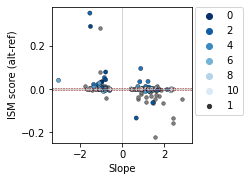

In [14]:
plt.figure(figsize=[2.5, 2.5])
plt.axvline(0, c='darkgrey', linewidth=0.5)
plt.axhline(-0.005, c='maroon', linewidth=0.5, linestyle='--')
plt.axhline(0, c='darkgrey', linewidth=0.5)
plt.axhline(0.005, c='maroon', linewidth=0.5, linestyle='--')
sns.scatterplot(x=sQTL_inrange['slope'].values[np.isnan(location)], 
                y=(res_glia['altISM'] - res_glia['refISM'])[np.isnan(location)], 
                color='gray', linewidth=0.3, edgecolor='black',
                s=14)
sns.scatterplot(x=sQTL_inrange['slope'].values, 
                y=res_glia['altISM'] - res_glia['refISM'], 
                hue=np.log2(location), linewidth=0.3, size=1, 
                edgecolor='black',
                palette='Blues_r',  
               )
plt.xlabel('Slope')
plt.ylabel('ISM score (alt-ref)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim([-3.3,3.3])
plt.show()

### Confusion matrix

In [15]:
res_glia['delta'] = np.abs(res_glia['altISM'] - res_glia['refISM'])
res_glia['difference'] = res_glia['altISM'] - res_glia['refISM']


In [16]:
thres = 0.005
res_glia_filt = res_glia[res_glia['delta'] > thres]

print(len(np.unique(res_glia_filt['Exon'])))
print(len(np.unique(res_glia_filt['Intron'])))
print(len(res_glia_filt))

67
61
71


In [17]:
from sklearn.metrics import confusion_matrix, classification_report

ypred = (res_glia_filt['refISM'] - res_glia_filt['altISM']) > 0
ytrue = res_glia_filt['slope'].values > 0

print(confusion_matrix(ytrue, ypred, labels=[True,False]))

print(classification_report(ytrue, ypred))

ypred = (res_glia['refISM'] - res_glia['altISM']) > 0
ytrue = res_glia['slope'].values > 0

print(confusion_matrix(ytrue, ypred, labels=[True,False]))

print(classification_report(ytrue, ypred))


[[30  8]
 [ 4 29]]
              precision    recall  f1-score   support

       False       0.78      0.88      0.83        33
        True       0.88      0.79      0.83        38

    accuracy                           0.83        71
   macro avg       0.83      0.83      0.83        71
weighted avg       0.84      0.83      0.83        71

[[124  84]
 [ 41  77]]
              precision    recall  f1-score   support

       False       0.48      0.65      0.55       118
        True       0.75      0.60      0.66       208

    accuracy                           0.62       326
   macro avg       0.61      0.62      0.61       326
weighted avg       0.65      0.62      0.62       326



#### Figure 4G

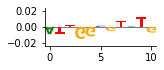

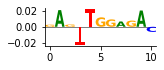

In [18]:
import logomaker

i = np.where(genes == 'chr5_168497947_168498046_ENSG00000113643_+')[0][0]
begin1 = 2996-5
end1 = 2996+6

begin2 = 3098-5
end2 = 3098+6

fig = plt.figure(figsize=(2,0.7))
ax = fig.add_subplot(111) 

df = pd.DataFrame(np.multiply(ism_glia[i][:,begin1:end1], sequences[i][:,begin1:end1]), index=['A', 'C', 'G', 'T']).T
df.index.name = 'pos'

crp_logo = logomaker.Logo(df, ax=ax)
plt.ylim([-0.024,0.024])
sns.despine()
plt.show()

fig = plt.figure(figsize=(2,0.7))
ax = fig.add_subplot(111) 

df = pd.DataFrame(np.multiply(ism_glia[i][:,begin2:end2], sequences[i][:,begin2:end2]), index=['A', 'C', 'G', 'T']).T
df.index.name = 'pos'

crp_logo = logomaker.Logo(df, ax=ax)
sns.despine()
plt.ylim([-0.024,0.024])
plt.show()

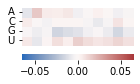

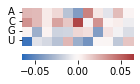

In [19]:
plt.figure(figsize=(2,1))
sns.heatmap(ism_glia[i][:,begin1:end1], cmap='vlag', center=0,
           vmin=-0.065, vmax=0.065, 
            cbar_kws=dict(orientation='horizontal'))
plt.yticks([0.4,1.4,2.4,3.4], ['A','C','G','U'], rotation=0)
plt.xticks([])
plt.show()

plt.figure(figsize=(2,1))
sns.heatmap(ism_glia[i][:,begin2:end2], cmap='vlag', center=0,
           vmin=-0.065, vmax=0.065, 
            cbar_kws=dict(orientation='horizontal'))
plt.yticks([0.4,1.4,2.4,3.4], ['A','C','G','U'], rotation=0)
plt.xticks([])
plt.show()
